#### TEAM MEMBERS

* Swaroop Bhandary K
* Deepansh Pandey

### Importing the Libraries

In [1]:
import os
import csv
import random
import shutil
import imutils
import cv2
import torch
import time
import numpy as np
from torch import nn
from torch.optim import Adam
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from collections import defaultdict
from skimage.io import imread
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from IPython.core.debugger import set_trace
from zipfile import ZipFile

### Extracting the Dataset

In [2]:
# Removing Already exsisting images and validation dataset folders
if(os.path.exists('robots_dataset/images')): shutil.rmtree('robots_dataset/images')
if(os.path.exists('robots_dataset/val_images')): shutil.rmtree('robots_dataset/val_images')
if(os.path.exists('robots_dataset/test')): shutil.rmtree('robots_dataset/test')

In [3]:
with ZipFile('robots_dataset/dataset.zip', 'r') as extractor:
    extractor.extractall('robots_dataset/')
    print('Unzipping Dataset Done')

Unzipping Dataset Done


### Setting the global parameters

In [4]:
np.random.seed(1)
random.seed(33)
torch.manual_seed(1)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(1)

if(os.path.exists("robots_dataset/val_images/") != True):os.mkdir('robots_dataset/val_images/')    
if(os.path.exists("robots_dataset/test/") != True):os.mkdir('robots_dataset/test/')    
xml_folder_path = 'robots_dataset/xml/'
csv_path = 'robots_dataset/labels.csv'
img_path = 'robots_dataset/images/'
img_val_path = 'robots_dataset/val_images/'
img_test_path = 'robots_dataset/test/'
model_path = 'robots_dataset/model.pt'

### Generating the label.csv

In [5]:
with open(csv_path, 'w') as csvfile:
    fieldnames = ['image_name', 'part_name', 'center_x', 'center_y']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    for xml_name in os.listdir(xml_folder_path):
        xml_path = xml_folder_path + xml_name
        tree = ET.parse(xml_path)
        root = tree.getroot()

        img_name = root.find('filename').text
        objects = root.findall('object')

        for part in objects:
            name = part.find('name').text
            object_bb = part.find('bndbox')
            xmin = int(object_bb.find('xmin').text)
            xmax = int(object_bb.find('xmax').text)
            ymin = int(object_bb.find('ymin').text)
            ymax = int(object_bb.find('ymax').text)

            center_x = (xmin+xmax) // 2
            center_y = (ymin+ymax) // 2

            writer.writerow({'image_name': img_name, 'part_name': name,
                             'center_x': center_x, 'center_y': center_y})            


### Randomly Selecting 10% as Validation Set

In [6]:
total_dataset_size = len([name for name in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, name))])
validation_set_size = round(total_dataset_size*0.2)
test_set_size = round(total_dataset_size*0.1)
filenames = random.sample(os.listdir(img_path), validation_set_size)
for fname in filenames:
    srcpath = os.path.join(img_path, fname)
    shutil.move(srcpath,img_val_path)   
filenames = random.sample(os.listdir(img_path), test_set_size)
for fname in filenames:
    srcpath = os.path.join(img_path, fname)
    shutil.move(srcpath,img_test_path) 
train_dataset_size = len([name for name in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, name))])
print("Number of Images in Dataset - ",total_dataset_size)
print("Train Dataset - ",train_dataset_size)
print("Validation Dataset - ",validation_set_size)
print("Test Dataset - ",test_set_size)

Number of Images in Dataset -  1867
Train Dataset -  1307
Validation Dataset -  373
Test Dataset -  187


### Function Definiton

In [7]:
class detection_dataset(Dataset):
    def __init__(self, img_size, img_folder_path, csv_path, transform=True):
        self.height = img_size[1]
        self.width = img_size[0]
        self.folder_path = img_folder_path
        self.img_files = os.listdir(img_folder_path)
        self.csv_path = csv_path
        self.transform = transform
        self.get_annotations()
        
    def __len__(self):
        return (len(self.img_files))
    
    def __getitem__(self, index):
        img_name = self.img_files[index]
        img = imread(self.folder_path + img_name)
        annotation = self.annotations[img_name]
        annotation = annotation[:,::4,::4]
        if self.transform:
            img = img.transpose((2,0,1))
            img, annotation = torch.from_numpy(img), torch.from_numpy(annotation)
            img = img.type(torch.FloatTensor)
            img = img/255
            annotation = annotation.type(torch.FloatTensor)
        sample = {'image':img, 'annotation':annotation}
        return sample
          
    def get_annotations(self):
        self.annotations = defaultdict(lambda: np.zeros([4, self.height, self.width]))
        part_mapping = {'Head':0, 'Foot':1, 'Hand':2, 'Trunk':3}
        with open(self.csv_path) as csvfile:
            readCSV = csv.reader(csvfile)
            for row in readCSV:
                img_name = row[0]
                img_annotation = self.annotations[img_name]
                channel = part_mapping[row[1].capitalize()]
                x = int(row[3])
                y = int(row[2])
                
                if img_annotation[channel, x-8:x+8, y-8:y+8].shape != (16,16): continue
                img_annotation[channel, x-8:x+8, y-8:y+8] = makeGaussian(16,8)
                

def makeGaussian(size, fwhm = 3):
    ''' 
    Input: size: length of a side of the square
           fwhm: full-width-half-maximum (effective radius)
    Output: a square gaussian kernel
    Reference: https://stackoverflow.com/a/14525830
    '''

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    x0 = y0 = size // 2

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

### Visualize the dataset

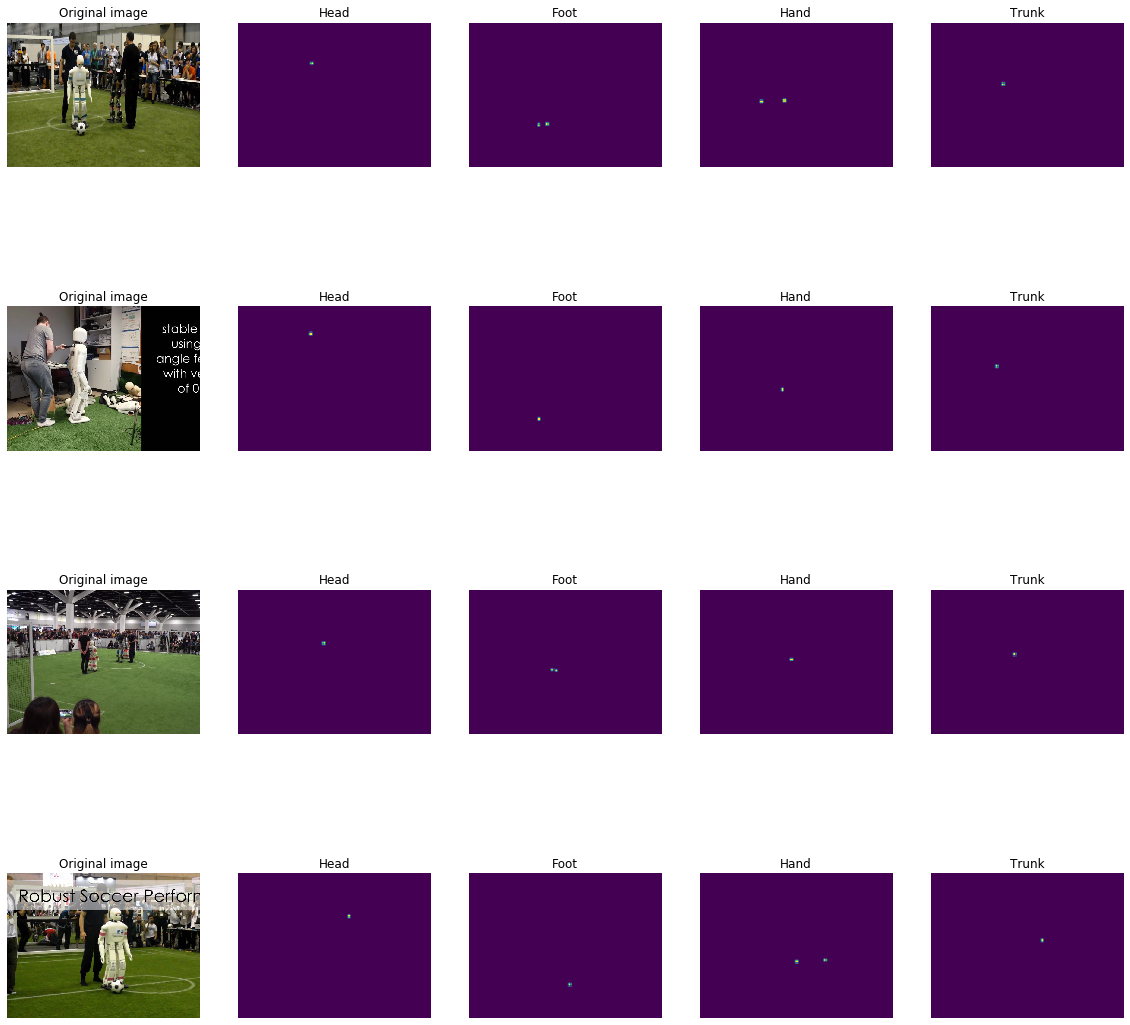

In [8]:
dg = detection_dataset((640,480), img_path, csv_path)
dataloader = DataLoader(dg, batch_size=4, shuffle=True)

data = next(iter(dataloader))
imgs, annotations = data['image'], data['annotation']

plt.figure(figsize=(20,20))

_to_pil = transforms.ToPILImage()
feat_labels = ['Head', 'Foot', 'Hand', 'Trunk']

for img_idx, img in enumerate(imgs):
    annotation = annotations[img_idx]
    plt.subplot(4,5,5*img_idx+1)
    plt.axis('off')
    plt.title('Original image')
    plt.imshow(_to_pil(img))
    for feat_idx in range(4):
        plt.subplot(4,5, 5*img_idx+feat_idx+2)
        plt.axis('off')
        plt.title(feat_labels[feat_idx])
        plt.imshow(_to_pil(annotation[feat_idx,:]))
plt.show()

### Create model

In [9]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class Model(nn.Module):
    def __init__(self, resnet):
        super(Model, self).__init__()
        self.downsampling = resnet

        self.cat1 = nn.Conv2d(64, 128, 1)
        self.cat2 = nn.Conv2d(128, 128, 1)
        self.cat3 = nn.Conv2d(256, 128, 1)
        
        self.upsampling_1 = nn.Sequential(nn.ReLU(),
                                          nn.ConvTranspose2d(512, 128, 3, 2, 1, 1)
                                         )

        self.upsampling_2 = nn.Sequential(nn.ReLU(),
                                          nn.BatchNorm2d(256),
                                          nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
                                         )

        self.upsampling_3 = nn.Sequential(nn.ReLU(),
                                          nn.BatchNorm2d(256),
                                          nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
                                         )

        self.upsampling_4 = nn.Sequential(nn.ReLU(),
                                         nn.BatchNorm2d(256),
                                         nn.ConvTranspose2d(256, 4, 3, 1, 1),
                                         nn.Sigmoid()
                                        )

    def forward(self, x):
        x = self.downsampling.conv1(x)
        x = self.downsampling.bn1(x)
        x = self.downsampling.relu(x)
        x = self.downsampling.maxpool(x)

        down1 = self.downsampling.layer1(x)
        cat1 = self.cat1(down1)
        down2 = self.downsampling.layer2(down1)
        cat2 = self.cat2(down2)
        down3 = self.downsampling.layer3(down2)
        cat3 = self.cat3(down3)
        down4 = self.downsampling.layer4(down3)  

        up1 = self.upsampling_1(down4)
        up2 = self.upsampling_2(torch.cat((up1, cat3), 1))
        up3 = self.upsampling_3(torch.cat((up2, cat2), 1))
        up4 = self.upsampling_4(torch.cat((up3, cat1), 1))
        
        return up4       

### Metrics to evaluate the model

In [10]:
def detection_metrics(out, annotation):
    '''
    Returns the true positive, false positive, true negative and false negative values
    ''' 
    tp, fp, fn = 0,0,0

    for idx, img_out in enumerate(out):
        detected_parts = get_part_centers(img_out)
        gt_parts = get_part_centers(annotation[idx])
        
        for detected_part, gt_part in zip(detected_parts, gt_parts):
            for val in detected_part:
                if not val: continue
                x = val[0]
                y = val[1]
                for gt_x, gt_y in gt_part:
                    if np.abs(x-gt_x) < 4 and np.abs(y-gt_y) < 4:
                        tp += 1
                        break
                else:
                    fp += 1
                    
            for gt_x, gt_y in gt_part:
                for x,y in detected_part:
                    if np.abs(x-gt_x) < 4 and np.abs(y-gt_y) < 4:
                        break
                else:
                    fn += 1
    return tp, fp, fn

def get_part_centers(img_out):
    '''
    Decodes the network output for one image
    '''
    out = img_out.cpu().detach().numpy()
    out = np.uint8(out * 255)
    
    out = np.clip(out, 0, 255)
        
    detected_parts = []
    for part in out:
        blurred_part = cv2.GaussianBlur(part, (5, 5), 0)
        thresh_part = cv2.threshold(blurred_part, 60, 255, cv2.THRESH_BINARY)[1]
        cnts_part = cv2.findContours(thresh_part, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts_part = imutils.grab_contours(cnts_part)

        part_loc = []
        for c in cnts_part:
            M = cv2.moments(c)
            if M["m00"] != 0:
                c_x = int(M["m10"] / M["m00"]) 
                c_y = int(M["m01"] / M["m00"]) 
            else:
                c_x = 0
                c_y = 0
            part_loc.append([c_x, c_y])
        detected_parts.append(part_loc)
    return detected_parts

### Fit the model to the data

In [11]:
losses = []
train_accuracies = []
train_fdrs = []
train_recalls = []
test_accuracies = []
test_fdrs = []
test_recalls = []

def fit(model, optimizer, num_epochs):
    
    criterion = nn.MSELoss()
    criterion.cuda()
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for data in train_dataloader:
            image, annotation = data['image'], data['annotation']
            image, annotation = image.cuda(), annotation.cuda()   
            pred = model(image)   
            loss = criterion(pred, annotation)
            optimizer.zero_grad()
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()

        losses.append(epoch_loss)
        print("loss for epoch {} is {}".format(epoch, epoch_loss))
        if (epoch+1) % 5 == 0:
            print("##"*30)
            print("Metrics for epoch {} is".format(epoch+1))

            model.eval()
            
            tp_epoch, fp_epoch, fn_epoch = 0, 0, 0
            for data in train_dataloader:
                image, annotation = data['image'], data['annotation']
                image, annotation = image.cuda(), annotation.cuda()
                pred = model(image)
                tp, fp, fn = detection_metrics(pred, annotation)
                tp_epoch += tp
                fp_epoch += fp
                fn_epoch += fn
            acc = (tp_epoch) / (tp_epoch + fp_epoch + fn_epoch)
            recall = tp_epoch / (tp_epoch + fn_epoch)
            fdr = fp_epoch / (fp_epoch + tp_epoch)
            train_accuracies.append(acc)
            train_recalls.append(recall)
            train_fdrs.append(fdr)
            print("Train acc = {}, Train FDR = {}, Train Recall = {}".format(acc, fdr, recall))
            
            tp_epoch, fp_epoch, fn_epoch = 0, 0, 0
            for data in val_dataloader:
                image, annotation = data['image'], data['annotation']
                image, annotation = image.cuda(), annotation.cuda()
                pred = model(image)
                tp, fp, fn = detection_metrics(pred, annotation)
                tp_epoch += tp
                fp_epoch += fp
                fn_epoch += fn
            acc = (tp_epoch) / (tp_epoch + fp_epoch + fn_epoch)
            recall = tp_epoch / (tp_epoch + fn_epoch)
            fdr = fp_epoch / (fp_epoch + tp_epoch)
            test_accuracies.append(acc)
            test_recalls.append(recall)
            test_fdrs.append(fdr)
            print("Val acc = {}, Val FDR = {}, Val Recall = {}".format(acc, fdr, recall))

In [12]:
resnet = resnet18(pretrained=True)
resnet.avgpool = Identity()
resnet.fc = Identity()

for param in resnet.parameters():
    param.requires_grad = False

model = Model(resnet)
print(model)

Model(
  (downsampling): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [13]:
start_time = time.time()
train_dg = detection_dataset((640,480), img_path, csv_path)
train_dataloader = DataLoader(train_dg, batch_size=3, shuffle=True)

val_dg = detection_dataset((640,480), img_val_path, csv_path)
val_dataloader = DataLoader(val_dg, batch_size=3, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
model.cuda()

fit(model, optimizer, num_epochs=150)

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
fit(model, optimizer, num_epochs=100)
end_time = time.time()

loss for epoch 0 is 46.19116698205471
loss for epoch 1 is 6.8188868765719235
loss for epoch 2 is 2.2558068498037755
loss for epoch 3 is 0.7839789901045151
loss for epoch 4 is 0.24248808577249292
############################################################
Metrics for epoch 5 is
Train acc = 0.0, Train FDR = 1.0, Train Recall = 0.0
Val acc = 0.0, Val FDR = 1.0, Val Recall = 0.0
loss for epoch 5 is 0.0965769038448343
loss for epoch 6 is 0.08530344849714311
loss for epoch 7 is 0.08048600591428112
loss for epoch 8 is 0.07656799389224034
loss for epoch 9 is 0.07316035366966389
############################################################
Metrics for epoch 10 is
Train acc = 0.01891468823375946, Train FDR = 0.6133333333333333, Train Recall = 0.019499731038192577
Val acc = 0.02281021897810219, Val FDR = 0.5238095238095238, Val Recall = 0.02339728591483388
loss for epoch 10 is 0.0697192025691038
loss for epoch 11 is 0.06659819540072931
loss for epoch 12 is 0.06401452858699486
loss for epoch 13 is

In [14]:
print("Model Total Running Time",(end_time-start_time)/3600,"Hours")

Model Total Running Time 6.244872925546434 Hours


### Graphical Representation of Output

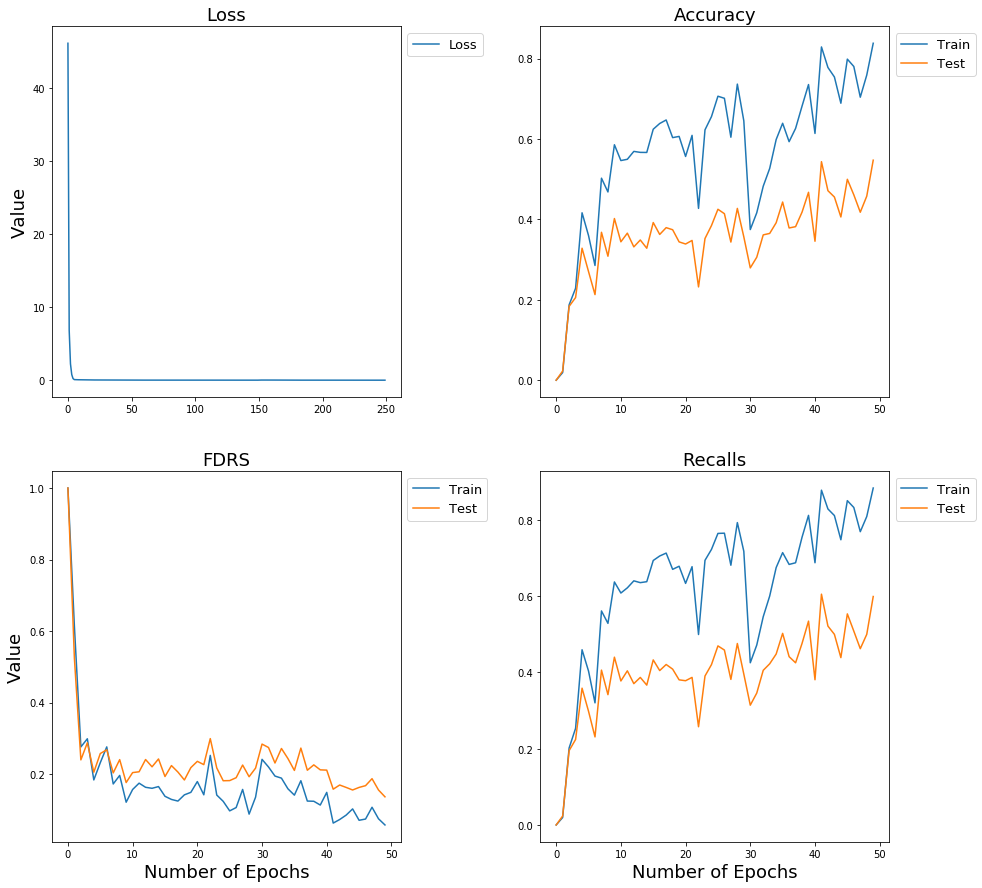

In [15]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))

# Plotting the graph for Loss
axs[0, 0].plot(losses,label='Loss')
axs[0, 0].set_ylabel("Value",fontsize=18)
axs[0, 0].set_title("Loss",fontsize=18)
axs[0, 0].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,fontsize=13)



# Plotting the graph for Accuracies
axs[0, 1].plot(train_accuracies,label='Train')
axs[0, 1].plot(test_accuracies,label='Test')
axs[0, 1].set_title("Accuracy",fontsize=18)
axs[0, 1].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=13)


# Plotting the graph for FDRS
axs[1, 0].plot(train_fdrs,label='Train')
axs[1, 0].plot(test_fdrs,label='Test')
axs[1, 0].set_xlabel("Number of Epochs",fontsize=18)
axs[1, 0].set_ylabel("Value",fontsize=18)
axs[1, 0].set_title("FDRS",fontsize=18)
axs[1, 0].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=13)


# Plotting the graph for Recalls
axs[1, 1].plot(train_recalls,label='Train')
axs[1, 1].plot(test_recalls,label='Test')
axs[1, 1].set_xlabel("Number of Epochs",fontsize=18)
axs[1, 1].set_title("Recalls",fontsize=18)
axs[1, 1].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=13)

plt.rc('xtick',labelsize=13)
plt.rc('ytick',labelsize=13)

plt.subplots_adjust(hspace = 0.2,wspace = 0.4)

### Saving the model

In [16]:
#torch.save(model.state_dict(), model_path)
# Loading the model
#model = Model(*args, **kwargs)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()

Model(
  (downsampling): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [26]:
test_dg = detection_dataset((640,480), img_test_path, csv_path)
test_dataloader = DataLoader(test_dg, batch_size=1, shuffle=True)

tp_epoch, fp_epoch, fn_epoch = 0, 0, 0
for data in test_dataloader:
    image, annotation = data['image'], data['annotation']
    image, annotation = image.cuda(), annotation.cuda()
    pred = model(image)
    tp, fp, fn = detection_metrics(pred, annotation)
    tp_epoch += tp
    fp_epoch += fp
    fn_epoch += fn
acc = (tp_epoch) / (tp_epoch + fp_epoch + fn_epoch)
recall = tp_epoch / (tp_epoch + fn_epoch)
fdr = fp_epoch / (fp_epoch + tp_epoch)
print("Test acc = {}, Test FDR = {}, Test Recall = {}".format(acc, fdr, recall))


Test acc = 0.5418392709196355, Test FDR = 0.1517509727626459, Test Recall = 0.6


### Model Best Predictions

In [18]:
all_accuracy = []
all_prediction = []
all_annotation = []
best_prediction = []
best_annotation = []
all_images = []
best_images = []

In [19]:
for data in test_dataloader:
    image, annotation = data['image'], data['annotation']
    image, annotation = image.cuda(), annotation.cuda()
    pred = model(image)
    tp, fp, fn = detection_metrics(pred, annotation)
    accuracy = ((tp) / (tp + fp + fn))
    for idx, img_out in enumerate(pred):
        detected_parts = get_part_centers(img_out)
        gt_parts = get_part_centers(annotation[idx])
    all_accuracy.append(accuracy)
    all_prediction.append(detected_parts)
    all_annotation.append(gt_parts)
    all_images.append(image.cpu().detach())

In [20]:
best_image_ind = np.argpartition(all_accuracy, -5)[-5:]

In [21]:
print("5 Best Images Accuracy \n")
for i in best_image_ind:
    print("Predicted Values",all_prediction[i])
    best_prediction.append(all_prediction[i])
    print("Actual Values",all_annotation[i])
    best_annotation.append(all_annotation[i])
    print("\n")
    best_images.append(all_images[i])

5 Best Images Accuracy 

Predicted Values [[[42, 55]], [[41, 95], [46, 93]], [[40, 82], [47, 77]], [[42, 71]]]
Actual Values [[[42, 55]], [[40, 96], [46, 93]], [[40, 81], [46, 77]], [[42, 72]]]


Predicted Values [[[38, 45]], [[40, 76], [34, 75]], [[44, 65], [30, 63]], [[37, 57]]]
Actual Values [[[38, 46]], [[39, 75], [34, 76]], [[44, 64], [30, 63]], [[37, 57]]]


Predicted Values [[[33, 48]], [[39, 78], [34, 77]], [[41, 66], [29, 66]], [[35, 59]]]
Actual Values [[[32, 48]], [[40, 77], [34, 77]], [[41, 67], [29, 67]], [[34, 57]]]


Predicted Values [[[62, 20]], [[58, 88], [69, 85]], [[51, 60]], [[64, 51]]]
Actual Values [[[61, 21]], [[59, 86], [69, 83]], [[50, 60]], [[66, 49]]]


Predicted Values [[[50, 7]], [[50, 38], [54, 38]], [[46, 27], [57, 25]], [[51, 19]]]
Actual Values [[[50, 6]], [[51, 37]], [[46, 26], [57, 26]], [[51, 17]]]




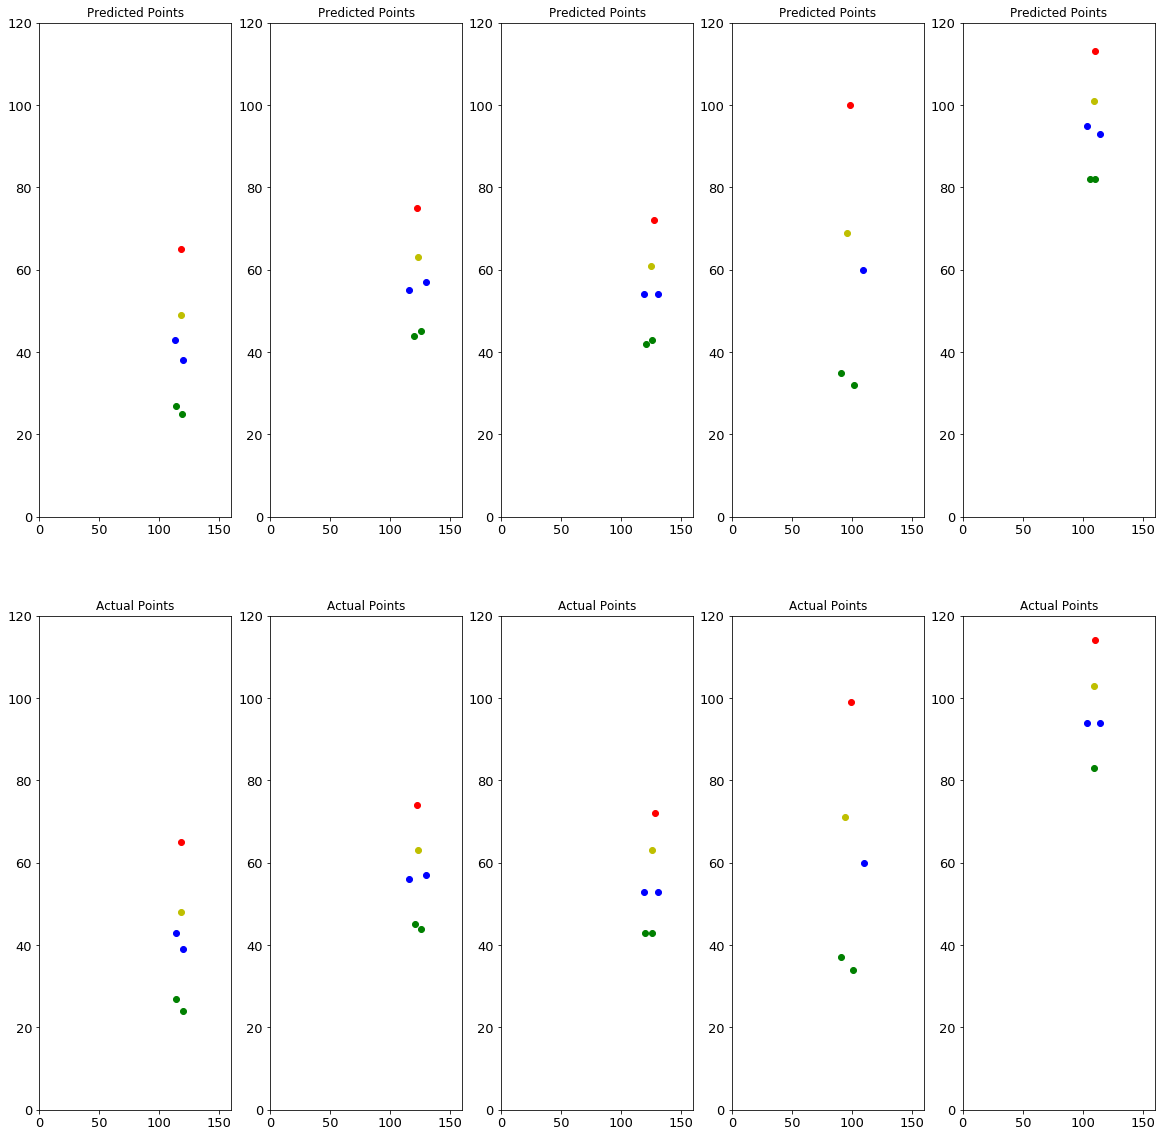

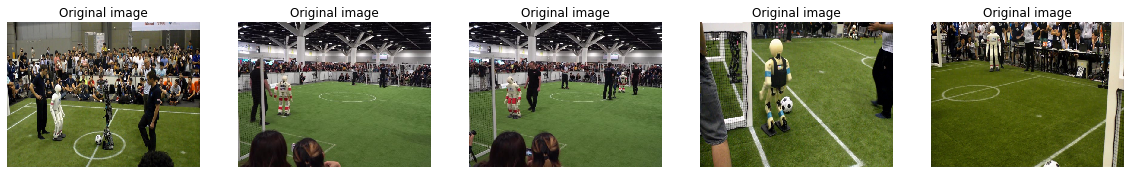

In [22]:
color = ['r', 'g', 'b', 'y']
fig, axs = plt.subplots(2, 5,figsize=(20,20))
graph_counter = 0
for i in range(len(best_prediction)):
    plt.axis(xmin=0, xmax=160, ymin=0, ymax=120)
    for idx, part in enumerate(best_prediction[i]):
                c = color[idx]
                for feat in part:
                    if not feat: continue
                    axs[0,graph_counter].scatter(160-feat[0], 120-feat[1], c=c)
                axs[0,graph_counter].set_xlim([0,160])
                axs[0,graph_counter].set_ylim([0,120])
                axs[0,graph_counter].set_title("Predicted Points")
    for ann_idx, part in enumerate(best_annotation[i]):
                c = color[ann_idx]
                for feat in part:
                    if not feat: continue
                    axs[1,graph_counter].scatter(160-feat[0], 120-feat[1], c=c)
                axs[1,graph_counter].set_xlim([0,160])
                axs[1,graph_counter].set_ylim([0,120])
                axs[1,graph_counter].set_title("Actual Points")
    graph_counter = graph_counter + 1

fig1 ,axs1 = plt.subplots(1,5,figsize=(20,20))
for j in range(len(best_prediction)):
    for img_idx, img in enumerate(best_images[j]):
        axs1[j].imshow(_to_pil(img))
        axs1[j].axis('off')
        axs1[j].set_title('Original image')

### Worst 5 Predictions

In [23]:
bad_prediction = []
bad_annotation = []
bad_images = []
bad_image_ind = np.argpartition(all_accuracy, 5)[:5]

In [24]:
print("5 Worst Images Accuracy \n")
for i in bad_image_ind:
    print("Predicted Values",all_prediction[i])
    bad_prediction.append(all_prediction[i])
    print("Actual Values",all_annotation[i])
    bad_annotation.append(all_annotation[i])
    print("\n")
    bad_images.append(all_images[i])

5 Worst Images Accuracy 

Predicted Values [[], [], [], []]
Actual Values [[[79, 60]], [[80, 96]], [[75, 82]], [[83, 72]]]


Predicted Values [[], [], [], []]
Actual Values [[[34, 84]], [[112, 86], [107, 76]], [[57, 93]], [[65, 82]]]


Predicted Values [[], [], [], []]
Actual Values [[[93, 10]], [[68, 95], [67, 74]], [[62, 50], [63, 32]], [[82, 49]]]


Predicted Values [[], [], [], [[123, 79]]]
Actual Values [[[27, 20]], [[26, 107], [34, 102]], [[4, 61], [51, 59]], [[28, 55]]]


Predicted Values [[], [], [], [[0, 0]]]
Actual Values [[[92, 18]], [[89, 105], [103, 102]], [[109, 64]], [[90, 52]]]




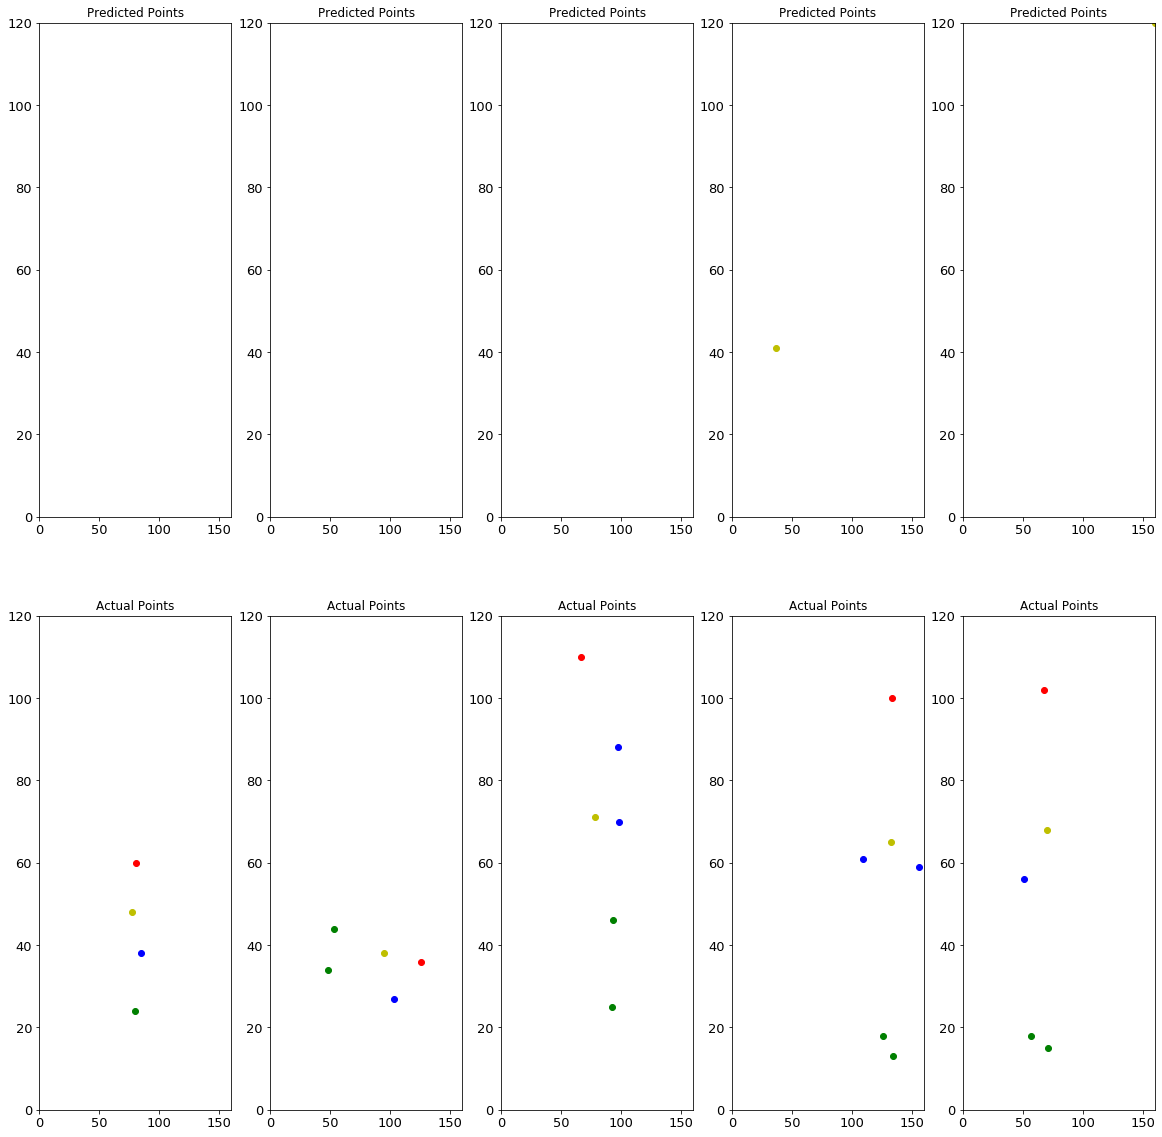

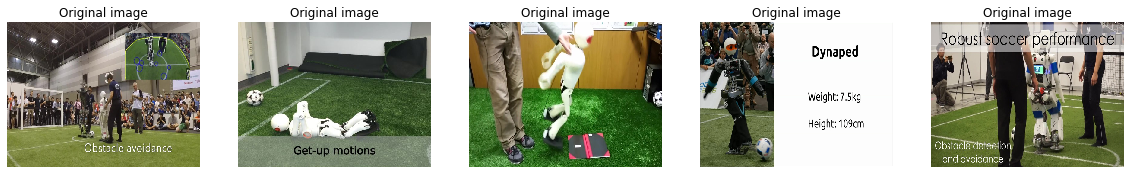

In [25]:
color = ['r', 'g', 'b', 'y']
fig, axs = plt.subplots(2, 5,figsize=(20,20))
graph_counter = 0
for i in range(len(bad_prediction)):
    plt.axis(xmin=0, xmax=160, ymin=0, ymax=120)
    for idx, part in enumerate(bad_prediction[i]):
                c = color[idx]
                for feat in part:
                    if not feat: continue
                    axs[0,graph_counter].scatter(160-feat[0], 120-feat[1], c=c)
                axs[0,graph_counter].set_xlim([0,160])
                axs[0,graph_counter].set_ylim([0,120])
                axs[0,graph_counter].set_title("Predicted Points")
    for ann_idx, part in enumerate(bad_annotation[i]):
                c = color[ann_idx]
                for feat in part:
                    if not feat: continue
                    axs[1,graph_counter].scatter(160-feat[0], 120-feat[1], c=c)
                axs[1,graph_counter].set_xlim([0,160])
                axs[1,graph_counter].set_ylim([0,120])
                axs[1,graph_counter].set_title("Actual Points")
    graph_counter = graph_counter + 1

fig1 ,axs1 = plt.subplots(1,5,figsize=(20,20))
for j in range(len(bad_prediction)):
    for img_idx, img in enumerate(bad_images[j]):
        axs1[j].imshow(_to_pil(img))
        axs1[j].axis('off')
        axs1[j].set_title('Original image')